In [ ]:
from uncertainties import unumpy as unp
import numpy as np
from matplotlib import pyplot as plt

from pisa.core.distribution_maker import DistributionMaker
from pisa.analysis.analysis import Analysis
from pisa import ureg

Let's load two distribution makers: one with the "classical" MultiDimBinning (test) and one with the variable binning (test_var). The test_var uses different energy and coszen binnings for different PID bins.

In [ ]:
test = DistributionMaker('resources/settings/pipeline/fast_example.cfg', profile=True)
test_var = DistributionMaker('resources/settings/pipeline/varbin_example.cfg', profile=True)

Getting the output of the distribution maker works in the same way for both. The difference is that "out" will be a MapSet, while "out_var" will be a list of MapSets. Get outputs several times to build up profiling statistics.

In [3]:
for i in range(100):
    out = test.get_outputs(return_sum=True)
    out_var = test_var.get_outputs(return_sum=True)

Let's look at the profiling output. Calculating the outputs with the variable binning should be slower due to the larger total number of bins and some overhead due to the splitting of the event sample.

In [4]:
test.report_profile()

Pipeline: neutrinos
- setup:        Total time (s): 0.037, n calls: 1
- run:          Total time (s): 0.948, n calls: 100, time/call (s): mean 0.009, max. 0.375, min. 0.005
- get_outputs:  Total time (s): 2.373, n calls: 100, time/call (s): mean 0.024, max. 0.386, min. 0.010
Individual services:
data simple_data_loader
- setup:    Total time (s): 0.002, n calls: 1
- compute:  Total time (s): +0.000, n calls: 1
- apply:    Total time (s): 0.015, n calls: 100, time/call (s): mean +0.000, max. +0.000, min. +0.000
flux barr_simple
- setup:    Total time (s): +0.000, n calls: 1
- compute:  Total time (s): 0.001, n calls: 1
- apply:    Total time (s): +0.000, n calls: 100, time/call (s): mean +0.000, max. +0.000, min. +0.000
osc prob3
- setup:    Total time (s): 0.032, n calls: 1
- compute:  Total time (s): 0.109, n calls: 1
- apply:    Total time (s): 0.276, n calls: 100, time/call (s): mean 0.003, max. 0.251, min. +0.000
aeff aeff
- setup:    Total time (s): +0.000, n calls: 1
- compute:  

In [5]:
test_var.report_profile()

Pipeline: neutrinos
- setup:        Total time (s): 0.015, n calls: 1
- run:          Total time (s): 0.311, n calls: 100, time/call (s): mean 0.003, max. 0.086, min. 0.002
- get_outputs:  Total time (s): 5.453, n calls: 100, time/call (s): mean 0.055, max. 0.234, min. 0.035
Individual services:
data simple_data_loader
- setup:    Total time (s): 0.002, n calls: 1
- compute:  Total time (s): +0.000, n calls: 1
- apply:    Total time (s): 0.014, n calls: 100, time/call (s): mean +0.000, max. +0.000, min. +0.000
flux barr_simple
- setup:    Total time (s): +0.000, n calls: 1
- compute:  Total time (s): 0.001, n calls: 1
- apply:    Total time (s): +0.000, n calls: 100, time/call (s): mean +0.000, max. +0.000, min. +0.000
osc prob3
- setup:    Total time (s): 0.009, n calls: 1
- compute:  Total time (s): 0.070, n calls: 1
- apply:    Total time (s): 0.035, n calls: 100, time/call (s): mean +0.000, max. 0.012, min. +0.000
aeff aeff
- setup:    Total time (s): +0.000, n calls: 1
- compute: 

For the first PID bin the outputs should be identical. 

In [6]:
a = unp.nominal_values(out['total'].hist[:,:,0])
b = unp.nominal_values(out_var[0]['total'].hist)
np.all(np.isclose(a, b))

True

In [7]:
a = unp.std_devs(out['total'].hist[:,:,0])
b = unp.std_devs(out_var[0]['total'].hist)
np.all(np.isclose(a, b))

True

For the second PID bin, since we use twice as many coszen bins for "out_var", we have to add up every two bins in the coszen dim to get the same binning as for "out".

In [8]:
a = unp.nominal_values(out['total'].hist)[:,:,1]
b = unp.nominal_values(out_var[1]['total'].hist[:,1::2]+out_var[1]['total'].hist[:,0::2])
np.all(np.isclose(a, b))

True

In [9]:
a = unp.std_devs(out['total'].hist)[:,:,1]
b = unp.std_devs(out_var[1]['total'].hist[:,1::2]+out_var[1]['total'].hist[:,0::2])
np.all(np.isclose(a, b))

True

Check if an Asimov fit that is not started at the truth, returns to it.

In [10]:
ana = Analysis()

In [11]:
# local minimizer
local_fit_minuit = {
    "method": "iminuit",
    "method_kwargs": {
        "errors": 0.1,
        "precision": 1e-14,  # default: double precision
        "tol": 1e-2,  # default: 0.1
        "run_simplex": False,
        "run_migrad": True
    },
    "local_fit_kwargs": None
}

# octant fit for local minimizer
fit_octant = {
    "method": "octants",
    "method_kwargs": {
        "angle": "theta23",
        "inflection_point": 45 * ureg.degrees,
    },
    "local_fit_kwargs": local_fit_minuit
}

In [12]:
test.params['aeff_scale'] = 0.9
test_var.params['aeff_scale'] = 0.9

In [ ]:
%%time
result = ana.fit_recursively(
    data_dist=out,
    hypo_maker=test,
    metric="mod_chi2",
    external_priors_penalty=None,
    **fit_octant
)

In [ ]:
%%time
result_var = ana.fit_recursively(
    data_dist=out_var,
    hypo_maker=test_var,
    metric="mod_chi2",
    external_priors_penalty=None,
    **fit_octant
)

Fit an N=10 pseudoexperiment ensemble and check if we fit the true parameter values on average (except for aeff which will be biased to higher values because of the chi2 metric).

In [ ]:
results = []
for i in range(10):
    PE = [d.fluctuate(method="poisson", random_state=i) for d in out_var]
    
    result_var = ana.fit_recursively(
        data_dist=PE,
        hypo_maker=test_var,
        metric="mod_chi2",
        external_priors_penalty=None,
        **fit_octant
    )
    
    results.append(result_var.params.free)

Text(0.5, 0, 'Aeff scale')

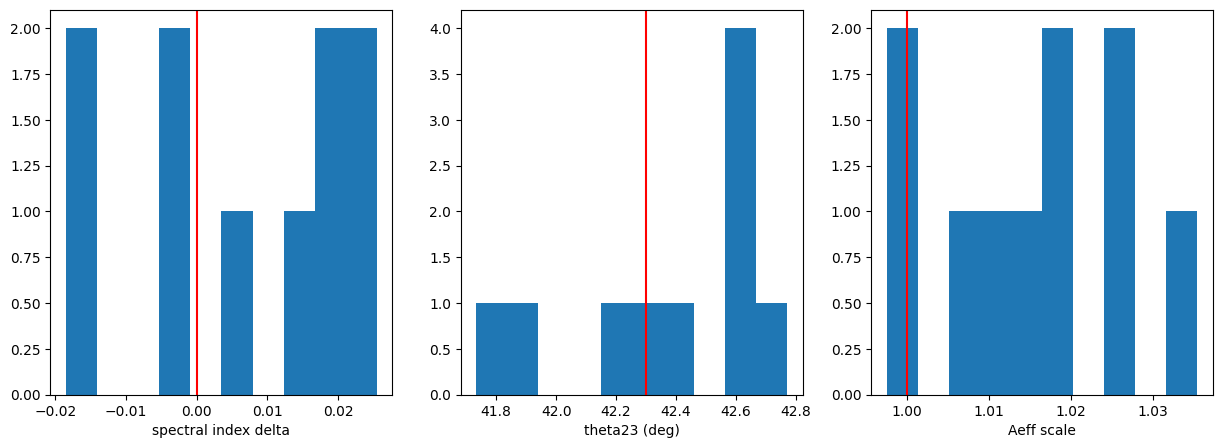

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist([p.delta_index.m for p in results])
plt.axvline(results[0].delta_index.nominal_value.m, color='red')
plt.xlabel("spectral index delta")

plt.subplot(132)
plt.hist([p.theta23.m for p in results])
plt.axvline(results[0].theta23.nominal_value.m, color='red')
plt.xlabel("theta23 (deg)")

plt.subplot(133)
plt.hist([p.aeff_scale.m for p in results])
plt.axvline(results[0].aeff_scale.nominal_value.m, color='red')
plt.xlabel("Aeff scale")